# EDA and Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
sns.set(style = 'white')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report,confusion_matrix
import joblib
import optuna
import os

**Let us read the data file in the python notebook**

In [2]:
telecom_cust = pd.read_csv('C:/Users/pr503/Projects/Customer/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
telecom_cust.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [5]:
telecom_cust=telecom_cust.drop(['customerID','MultipleLines','PhoneService','StreamingTV','StreamingMovies'],axis=1)

**Let's explore the data to see if there are any missing values.**

In [6]:
telecom_cust.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
telecom_cust.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

After looking at the above output, we can say that there are 11 missing values for Total Charges. Let us replace remove these 11 rows from our data set

In [8]:
telecom_cust.dropna(inplace = True)
telecom_cust = telecom_cust.iloc[:,1:]
telecom_cust['Churn'].replace(to_replace='Yes', value=1, inplace=True)
telecom_cust['Churn'].replace(to_replace='No',  value=0, inplace=True)
telecom_cust = pd.get_dummies(telecom_cust)
telecom_cust.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,...,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,True,False,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,True,False,True,False,True,...,True,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False


In [9]:
telecom_cust.isnull().sum()

SeniorCitizen                              0
tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_No internet service         0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_No internet service           0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProtection_No internet service       0
DeviceProtection_Yes                       0
TechSupport_No                             0
TechSuppor

<Axes: >

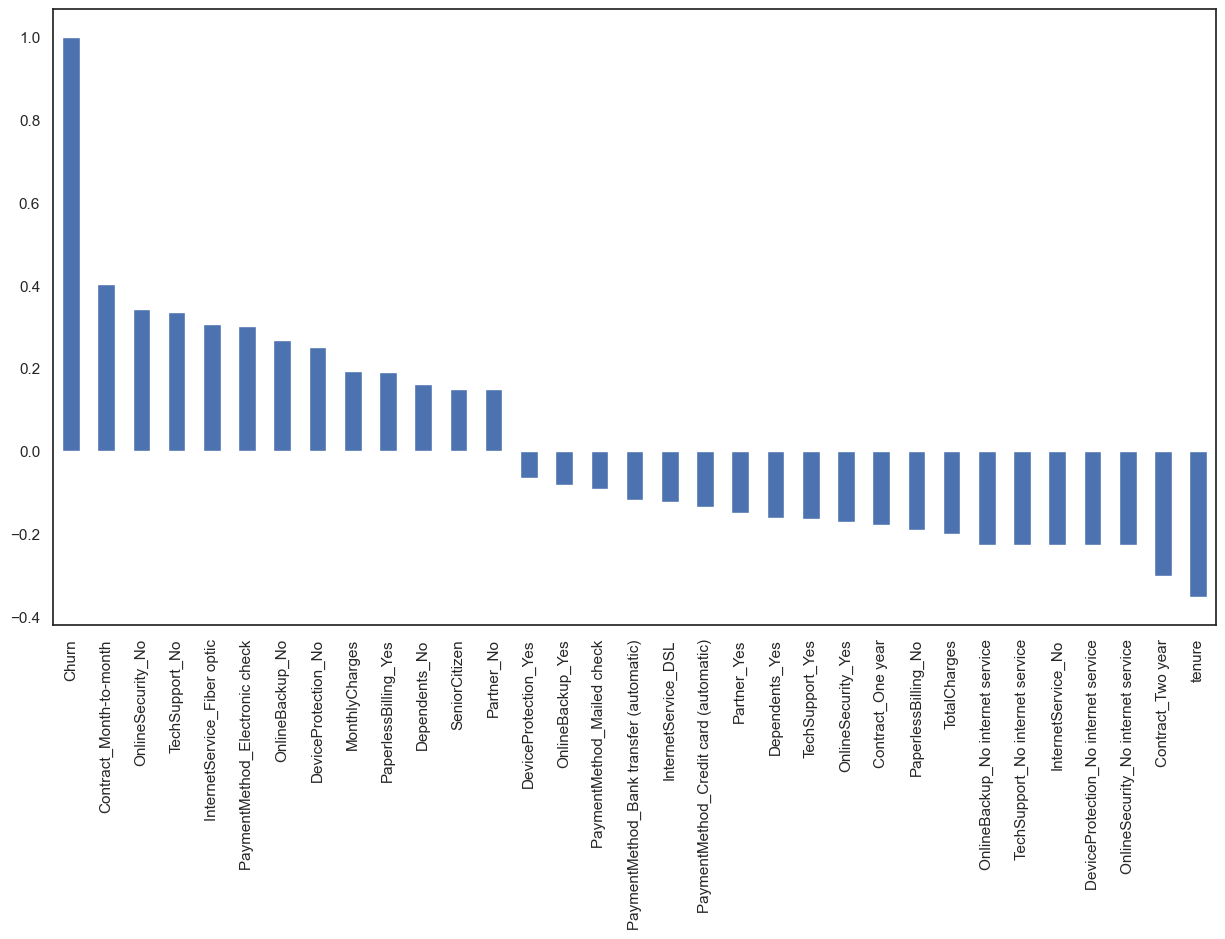

In [10]:
plt.figure(figsize=(15,8))
telecom_cust.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

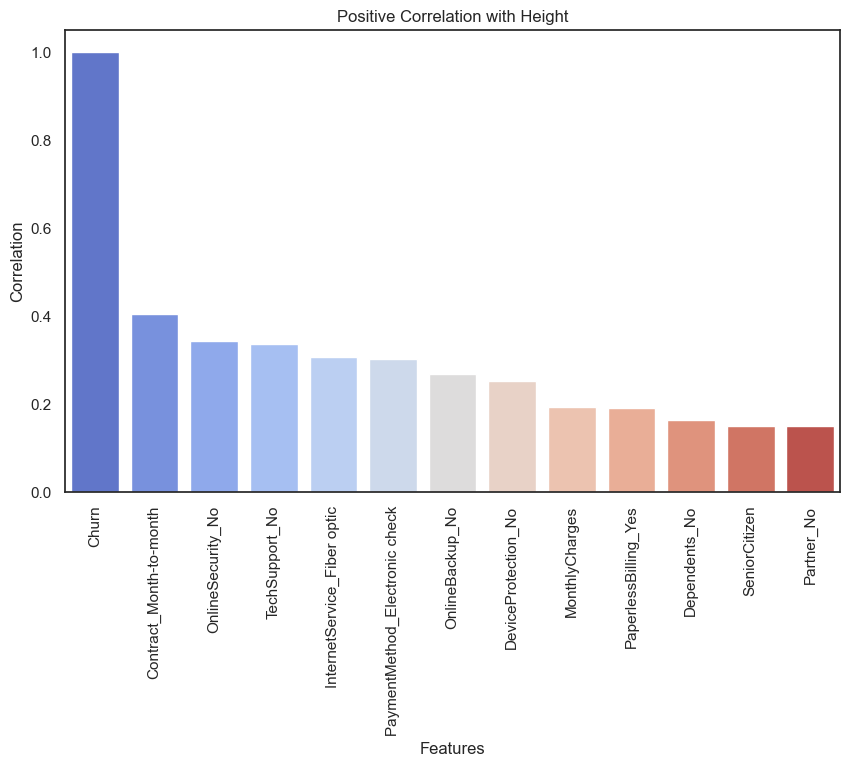

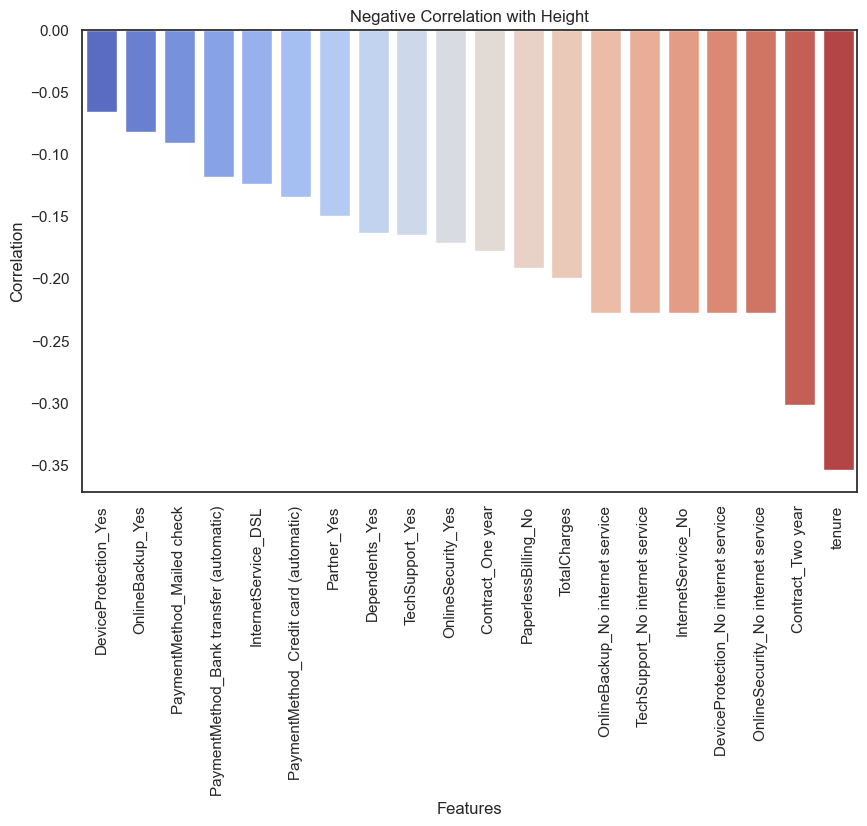

In [11]:
corr_matrix = telecom_cust.corr().sort_values(by='Churn', ascending=False)

positive_corr = corr_matrix[corr_matrix['Churn'] > 0]['Churn']
negative_corr = corr_matrix[corr_matrix['Churn'] < 0]['Churn']

plt.figure(figsize=(10, 6))
sns.barplot(x=positive_corr.index, y=positive_corr, palette='coolwarm')
plt.title('Positive Correlation with Height')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=negative_corr.index, y=negative_corr, palette='coolwarm')
plt.title('Negative Correlation with Height')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

In [12]:
def log_transform(X):
    return np.log1p(X)

pipeline = Pipeline([
    ('minmax_scale', MinMaxScaler()),
    ('log_transform', FunctionTransformer(log_transform))
])


In [13]:
def tomek_links (X,y) : 
    tl = TomekLinks(sampling_strategy='auto')
    X_resampled, y_resampled = tl.fit_resample(X, y)
    enn = EditedNearestNeighbours(n_neighbors= 12)
    X_resampled, y_resampled = enn.fit_resample(X, y)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    return X_resampled , y_resampled

In [14]:
X = telecom_cust.drop('Churn',axis=1)
y = telecom_cust['Churn']

In [15]:
print('Before TOMEK Shape=',len(X))
print(y.value_counts())

Before TOMEK Shape= 7032
Churn
0    5163
1    1869
Name: count, dtype: int64


In [16]:
X_r, y_r = tomek_links(X,y)

In [17]:
print('After TOMEK Shape=',len(X_r))
y_r.value_counts()

After TOMEK Shape= 3738


Churn
0    1869
1    1869
Name: count, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=99)

In [19]:
X_train_log = pipeline.fit_transform(X_train)
X_test_log = pipeline.transform(X_test)

In [20]:
logmodel = LogisticRegression(solver='lbfgs', max_iter=1000)
logmodel.fit(X_train_log, y_train)
predictions_log = logmodel.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_log)
print('log_r roc_auc(log): ',roc_auc) 

log_r roc_auc(log):  0.9841334709914251


In [21]:
predictions_logr_ = (predictions_log > 0.6).astype(int)
class_report_logr = classification_report(y_test, predictions_logr_,output_dict=True)
print("Classification Report:")
print(class_report_logr)

Classification Report:
{'0': {'precision': 0.9336734693877551, 'recall': 0.9289340101522843, 'f1-score': 0.9312977099236641, 'support': 394.0}, '1': {'precision': 0.9213483146067416, 'recall': 0.9265536723163842, 'f1-score': 0.9239436619718311, 'support': 354.0}, 'accuracy': 0.9278074866310161, 'macro avg': {'precision': 0.9275108919972483, 'recall': 0.9277438412343342, 'f1-score': 0.9276206859477476, 'support': 748.0}, 'weighted avg': {'precision': 0.9278404415903236, 'recall': 0.9278074866310161, 'f1-score': 0.927817318245925, 'support': 748.0}}


In [22]:
report_df1 = pd.DataFrame(class_report_logr).transpose()
print(report_df1)

              precision    recall  f1-score     support
0              0.933673  0.928934  0.931298  394.000000
1              0.921348  0.926554  0.923944  354.000000
accuracy       0.927807  0.927807  0.927807    0.927807
macro avg      0.927511  0.927744  0.927621  748.000000
weighted avg   0.927840  0.927807  0.927817  748.000000


In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logmodel, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.98366152 0.98126561 0.97007599 0.96729668 0.9768718 ]


**2. Light GBM**

In [24]:
# def objective(trial):
#     lgb_params = {
#     'objective': 'binary',  
#     'metric': 'auc',  
#     'num_class': 1,  
#     'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
#     'max_depth': trial.suggest_int('max_depth', 1, 800),
#     'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
#     'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#     'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#     'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 50),
#     'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
#     'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#     'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
#     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#     'num_leaves': trial.suggest_int('num_leaves', 10, 500),
#     'verbosity': -1 
# }

#     model = lgb.LGBMClassifier(**lgb_params,force_col_wise=True,)
#     model.fit(X_train_log,y_train)

#     y_pred = model.predict_proba(X_test_log)[:,1]

#     # Evaluate ROC AUC
#     roc_auc = roc_auc_score(y_test, y_pred)
#     return  roc_auc

# study = optuna.create_study(direction='maximize')

# study.optimize(objective, n_trials=50)

# best_params = study.best_params
# print("Best Parameters:", best_params)

In [25]:
lgbm_params_1 = {'n_estimators': 593, 'max_depth': 477, 'learning_rate': 0.08084077556973439, 'reg_alpha': 0.5571312746488691, 'reg_lambda': 0.8803561825353725, 'min_child_weight': 0.4899327254458796, 'min_child_samples': 29, 'subsample': 0.6222740946496832, 'subsample_freq': 10, 'colsample_bytree': 0.43499999871848116, 'num_leaves': 181}
lgbm_classifier_1 = LGBMClassifier(**lgbm_params_1, random_state=42,)
lgbm_classifier_1.fit(X_train_log,y_train)
predictions_lgbm_1 = lgbm_classifier_1.predict_proba(X_test_log)[:, 1]
roc_auc = roc_auc_score(y_test,predictions_lgbm_1)
print('lgbm roc_auc: ',roc_auc) 

[LightGBM] [Info] Number of positive: 1515, number of negative: 1475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2990, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506689 -> initscore=0.026757
[LightGBM] [Info] Start training from score 0.026757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [26]:
predictions_lgbm_ = (predictions_lgbm_1 > 0.5).astype(int)
class_report_lgbm = classification_report(y_test, predictions_lgbm_,output_dict=True)
print("Classification Report:")
print(class_report_lgbm)

Classification Report:
{'0': {'precision': 0.9714285714285714, 'recall': 0.949238578680203, 'f1-score': 0.9602053915275994, 'support': 394.0}, '1': {'precision': 0.9449035812672176, 'recall': 0.9689265536723164, 'f1-score': 0.9567642956764295, 'support': 354.0}, 'accuracy': 0.9585561497326203, 'macro avg': {'precision': 0.9581660763478945, 'recall': 0.9590825661762596, 'f1-score': 0.9584848436020145, 'support': 748.0}, 'weighted avg': {'precision': 0.9588753006837596, 'recall': 0.9585561497326203, 'f1-score': 0.9585768515124735, 'support': 748.0}}


In [27]:
report_df2 = pd.DataFrame(class_report_lgbm).transpose()
print(report_df2)

              precision    recall  f1-score     support
0              0.971429  0.949239  0.960205  394.000000
1              0.944904  0.968927  0.956764  354.000000
accuracy       0.958556  0.958556  0.958556    0.958556
macro avg      0.958166  0.959083  0.958485  748.000000
weighted avg   0.958875  0.958556  0.958577  748.000000


In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgbm_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

[LightGBM] [Info] Number of positive: 1201, number of negative: 1191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2392, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502090 -> initscore=0.008361
[LightGBM] [Info] Start training from score 0.008361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

**3. XG Boost**

In [29]:
# def objective(trial):
#     xgb_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 0, 1000),
#         'max_depth': trial.suggest_int('max_depth', 1, 200),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 100),
#         'max_delta_step': trial.suggest_float('max_delta_step', 0.1, 100),
#         'min_split_loss': trial.suggest_float('min_split_loss', 0.0, 1.0),
#         'lambda': trial.suggest_float('lambda', 0.0, 1.0),
#         'alpha': trial.suggest_float('alpha', 0.0, 1.0),
#      }


#     # Train XGBoost model
#     model = XGBClassifier(**xgb_params)
#     model.fit(X_train_log, y_train)

#     y_pred = model.predict_proba(X_test_log)[:,1]

#     # Evaluate log loss
#     roc_auc = roc_auc_score(y_test, y_pred)
#     return roc_auc  # Optuna

# study = optuna.create_study(direction='maximize')  # Use 'minimize' for log loss

# study.optimize(objective, n_trials=20)

# best_params = study.best_params
# print("Best Parameters:", best_params)

In [30]:
xgb_params_1 ={'n_estimators': 848, 'max_depth': 181, 'min_child_weight': 2.7126029894463066, 'learning_rate': 0.05515403480242501, 'subsample': 0.8354392345619088, 'gamma': 0.3941162707386998, 'colsample_bytree': 0.8799826300692483, 'colsample_bylevel': 0.984162562045952, 'colsample_bynode': 0.9932693796404883, 'reg_alpha': 0.582518627639365, 'reg_lambda': 0.5831000055931066, 'scale_pos_weight': 40.22082054341293, 'max_delta_step': 2.2557895960815726, 'min_split_loss': 0.28979235293151323, 'lambda': 0.4477325292952628, 'alpha': 0.02376398804955937}
xgb_classifier_1 = XGBClassifier(**xgb_params_1,random_state=42)
xgb_classifier_1.fit(X_train_log,y_train)
predictions_xgb = xgb_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_lgbm_1)
print('xgb roc_auc: ',roc_auc) 

xgb roc_auc:  0.993669161719579


In [31]:
predictions_xgb_ = (predictions_xgb > 0.5).astype(int)
class_report_xgb = classification_report(y_test, predictions_xgb_,output_dict=True)
print("Classification Report:")
print(class_report_xgb)

Classification Report:
{'0': {'precision': 0.9808743169398907, 'recall': 0.9111675126903553, 'f1-score': 0.9447368421052631, 'support': 394.0}, '1': {'precision': 0.9083769633507853, 'recall': 0.980225988700565, 'f1-score': 0.9429347826086957, 'support': 354.0}, 'accuracy': 0.9438502673796791, 'macro avg': {'precision': 0.944625640145338, 'recall': 0.9456967506954601, 'f1-score': 0.9438358123569794, 'support': 748.0}, 'weighted avg': {'precision': 0.9465640720594851, 'recall': 0.9438502673796791, 'f1-score': 0.9438839957659785, 'support': 748.0}}


In [32]:
report_df3 = pd.DataFrame(class_report_xgb).transpose()
print(report_df3)

              precision    recall  f1-score    support
0              0.980874  0.911168  0.944737  394.00000
1              0.908377  0.980226  0.942935  354.00000
accuracy       0.943850  0.943850  0.943850    0.94385
macro avg      0.944626  0.945697  0.943836  748.00000
weighted avg   0.946564  0.943850  0.943884  748.00000


In [33]:
cv_scores = cross_val_score(lgbm_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

[LightGBM] [Info] Number of positive: 1201, number of negative: 1191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2392, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502090 -> initscore=0.008361
[LightGBM] [Info] Start training from score 0.008361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

**4. HIST Gradient Boost**

In [34]:
# def objective(trial):
#     hgb_params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 31, 64),
#         'max_depth': trial.suggest_int('max_depth', 1, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
#         'max_bins': trial.suggest_int('max_bins', 2, 225),
#         'random_state': 42  # You can change or remove this depending on your preference
#     }

#     # Train HistGradientBoostingClassifier model
#     model = HistGradientBoostingClassifier(**hgb_params)
#     model.fit(X_train_log, y_train)

#     # Get predicted probabilities for positive class
#     y_pred_proba = model.predict_proba(X_test_log)[:, 1]

#     # Evaluate ROC AUC
#     roc_auc = roc_auc_score(y_test, y_pred_proba)
#     return roc_auc

# # Create Optuna study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# # Get the best parameters
# best_params = study.best_params
# print("Best Parameters:", best_params)

In [35]:
hist_params_1 = {'learning_rate': 0.07021095470218588, 'max_iter': 988, 'max_leaf_nodes': 64, 'max_depth': 13, 'min_samples_leaf': 9, 'l2_regularization': 0.46935506236151153, 'max_bins': 223}
hist_classifier_1 = HistGradientBoostingClassifier(**hist_params_1 , random_state=42,)
hist_classifier_1.fit(X_train_log, y_train)
predictions_hist = hist_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_hist)
print('catb roc_auc: ',roc_auc) 

catb roc_auc:  0.9949883850985115


In [36]:
predictions_hist_ = (predictions_hist > 0.5).astype(int)
class_report_hist = classification_report(y_test, predictions_hist_,output_dict=True)
print("Classification Report:")
print(class_report_hist)

Classification Report:
{'0': {'precision': 0.9716494845360825, 'recall': 0.9568527918781726, 'f1-score': 0.9641943734015347, 'support': 394.0}, '1': {'precision': 0.9527777777777777, 'recall': 0.9689265536723164, 'f1-score': 0.9607843137254902, 'support': 354.0}, 'accuracy': 0.9625668449197861, 'macro avg': {'precision': 0.96221363115693, 'recall': 0.9628896727752445, 'f1-score': 0.9624893435635125, 'support': 748.0}, 'weighted avg': {'precision': 0.9627182222467243, 'recall': 0.9625668449197861, 'f1-score': 0.9625805216297169, 'support': 748.0}}


In [37]:
report_df4 = pd.DataFrame(class_report_hist).transpose()
print(report_df4)

              precision    recall  f1-score     support
0              0.971649  0.956853  0.964194  394.000000
1              0.952778  0.968927  0.960784  354.000000
accuracy       0.962567  0.962567  0.962567    0.962567
macro avg      0.962214  0.962890  0.962489  748.000000
weighted avg   0.962718  0.962567  0.962581  748.000000


In [38]:
cv_scores = cross_val_score(hist_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.98768727 0.98236302 0.97658317 0.97918371 0.98363857]


**5. CatBoost**

In [39]:
# def objective(trial):
#     cat_params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'border_count': trial.suggest_int('border_count', 1, 255),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 100),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
#         'max_leaves': trial.suggest_int('max_leaves', 5, 64),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),

#     }

#     # Train CatBoost model
#     model = CatBoostClassifier(**cat_params, verbose=False)
#     model.fit(X_train_log, y_train,)

#     # Get predicted probabilities for positive class
#     y_pred_proba = model.predict_proba(X_test_log)[:, 1]

#     # Evaluate ROC AUC
#     roc_auc = roc_auc_score(y_test, y_pred_proba)
#     return roc_auc


# # Create Optuna study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best parameters
# best_params = study.best_params
# print("Best Parameters:", best_params)

In [40]:
cat_boost_params_1 = {'iterations': 387, 'depth': 8, 'learning_rate': 0.07187075009309823, 'l2_leaf_reg': 3.6015941733846244, 'border_count': 144, 'bagging_temperature': 0.10752133697343559, 'random_strength': 0.21349118508286785, 'scale_pos_weight': 14.076564512853938, 'min_data_in_leaf': 6, 'grow_policy': 'Lossguide'}
catb_classifier_1 = CatBoostClassifier(**cat_boost_params_1 , random_state=42, logging_level='Silent')
catb_classifier_1.fit(X_train_log, y_train)
predictions_catb = catb_classifier_1.predict_proba(X_test_log)[:,1]
roc_auc = roc_auc_score(y_test,predictions_catb)
print('catb roc_auc: ',roc_auc) 

catb roc_auc:  0.994006137256589


In [41]:
predictions_catb_ = (predictions_catb > 0.9).astype(int)
class_report_catb = classification_report(y_test, predictions_catb_,output_dict=True)
print("Classification Report:")
print(class_report_catb)

Classification Report:
{'0': {'precision': 0.9522613065326633, 'recall': 0.9619289340101523, 'f1-score': 0.9570707070707072, 'support': 394.0}, '1': {'precision': 0.9571428571428572, 'recall': 0.9463276836158192, 'f1-score': 0.9517045454545454, 'support': 354.0}, 'accuracy': 0.9545454545454546, 'macro avg': {'precision': 0.9547020818377603, 'recall': 0.9541283088129857, 'f1-score': 0.9543876262626263, 'support': 748.0}, 'weighted avg': {'precision': 0.9545715590941722, 'recall': 0.9545454545454546, 'f1-score': 0.9545311065197428, 'support': 748.0}}


In [42]:
report_df5 = pd.DataFrame(class_report_catb).transpose()
print(report_df5)

              precision    recall  f1-score     support
0              0.952261  0.961929  0.957071  394.000000
1              0.957143  0.946328  0.951705  354.000000
accuracy       0.954545  0.954545  0.954545    0.954545
macro avg      0.954702  0.954128  0.954388  748.000000
weighted avg   0.954572  0.954545  0.954531  748.000000


In [43]:
cv_scores = cross_val_score(catb_classifier_1, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.98782184 0.98292292 0.97838446 0.97835464 0.98605126]


In [44]:
knn = KNeighborsClassifier(
    n_neighbors=19,
    p=3
)
knn.fit(X_train_log, y_train)
predictions_knn = knn.predict_proba(X_test_log)[:,1]
roc_auc_knn = roc_auc_score(y_test,predictions_knn)
print('roc_auc knn', roc_auc_knn)

roc_auc knn 0.9723070635808311


In [45]:
predictions_knn_ = (predictions_knn > 0.6).astype(int)
class_report_knn = classification_report(y_test, predictions_knn_,output_dict=True)
print("Classification Report:")
print(class_report_knn)

Classification Report:
{'0': {'precision': 0.9342105263157895, 'recall': 0.9010152284263959, 'f1-score': 0.9173126614987079, 'support': 394.0}, '1': {'precision': 0.8940217391304348, 'recall': 0.9293785310734464, 'f1-score': 0.9113573407202216, 'support': 354.0}, 'accuracy': 0.9144385026737968, 'macro avg': {'precision': 0.9141161327231122, 'recall': 0.9151968797499211, 'f1-score': 0.9143350011094648, 'support': 748.0}, 'weighted avg': {'precision': 0.9151906992253944, 'recall': 0.9144385026737968, 'f1-score': 0.91449423428536, 'support': 748.0}}


In [46]:
report_df6 = pd.DataFrame(class_report_knn).transpose()
print(report_df6)

              precision    recall  f1-score     support
0              0.934211  0.901015  0.917313  394.000000
1              0.894022  0.929379  0.911357  354.000000
accuracy       0.914439  0.914439  0.914439    0.914439
macro avg      0.914116  0.915197  0.914335  748.000000
weighted avg   0.915191  0.914439  0.914494  748.000000


In [47]:
cv_scores = cross_val_score(knn, X_train_log, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)

Cross-validation ROC AUC scores: [0.96952095 0.96562189 0.95375176 0.95448536 0.96306895]


**Ensemble**

In [48]:
model1 = xgb_classifier_1
model2 = lgbm_classifier_1
model3 = logmodel
model4 = hist_classifier_1
#model5 = rf_classifier_1
model6 = knn
model7 = catb_classifier_1

ensemble_model = VotingClassifier(estimators=
                                  [
                                              ('model1', model1),
                                              ('model2', model2),
                                                ('model3', model3),
                                              ('model4', model4),
                                              #('model5', model5),
                                               ('model6', model6),
                                              ("model7", model7)
                                             ], 
                                  
                                  voting='soft')

In [49]:
ensemble_model.fit(X_train_log,y_train)
ensemble_predictions = ensemble_model.predict_proba(X_test_log)[:, 1]
roc_auc = roc_auc_score(y_test,ensemble_predictions)
print('Ensemble roc_auc: ',roc_auc) 

[LightGBM] [Info] Number of positive: 1515, number of negative: 1475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2990, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506689 -> initscore=0.026757
[LightGBM] [Info] Start training from score 0.026757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [50]:
ensemble_predictions_soft = (ensemble_predictions > 0.65).astype(int)
ensemble_predictions_soft_class_report_ = classification_report(y_test, ensemble_predictions_soft,output_dict=True)
print("Classification Report:\n")
print(ensemble_predictions_soft_class_report_)

Classification Report:

{'0': {'precision': 0.9689922480620154, 'recall': 0.9517766497461929, 'f1-score': 0.9603072983354674, 'support': 394.0}, '1': {'precision': 0.9473684210526315, 'recall': 0.9661016949152542, 'f1-score': 0.9566433566433565, 'support': 354.0}, 'accuracy': 0.9585561497326203, 'macro avg': {'precision': 0.9581803345573234, 'recall': 0.9589391723307236, 'f1-score': 0.958475327489412, 'support': 748.0}, 'weighted avg': {'precision': 0.9587585117500877, 'recall': 0.9585561497326203, 'f1-score': 0.9585732938448158, 'support': 748.0}}


In [51]:
report_df7 = pd.DataFrame(ensemble_predictions_soft_class_report_).transpose()
print(report_df7)

              precision    recall  f1-score     support
0              0.968992  0.951777  0.960307  394.000000
1              0.947368  0.966102  0.956643  354.000000
accuracy       0.958556  0.958556  0.958556    0.958556
macro avg      0.958180  0.958939  0.958475  748.000000
weighted avg   0.958759  0.958556  0.958573  748.000000


In [52]:
mreport=pd.concat([report_df1,report_df2,report_df3,report_df4,report_df5,report_df6,report_df7])

In [53]:
mreport.to_csv("reporrts.csv")

In [54]:
mreport

,precision,recall,f1-score,support
0,0.933673,0.928934,0.931298,394.000000
1,0.921348,0.926554,0.923944,354.000000
accuracy,0.927807,0.927807,0.927807,0.927807
macro avg,0.927511,0.927744,0.927621,748.000000
weighted avg,0.927840,0.927807,0.927817,748.000000
0,0.971429,0.949239,0.960205,394.000000
1,0.944904,0.968927,0.956764,354.000000
accuracy,0.958556,0.958556,0.958556,0.958556
macro avg,0.958166,0.959083,0.958485,748.000000
weighted avg,0.958875,0.958556,0.958577,748.000000


*Save the model*

In [55]:
#joblib.dump(emodel, 'emsemble_model.h5')